In [1]:
# import packages

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import fsolve
from lacbox.io import load_pwr, load_ind, load_inds, load_ae, load_pc, load_oper, load_cmb, load_amp
from lacbox.vis import plot_amp
from lacbox.test import test_data_path
from myteampack import MyHTC
from scipy.interpolate import interp1d

from our_values import *

plt.rcParams.update({'font.family': 'serif', 'font.size':14})


## STRUCTURAL DIAGRAM

0.596767


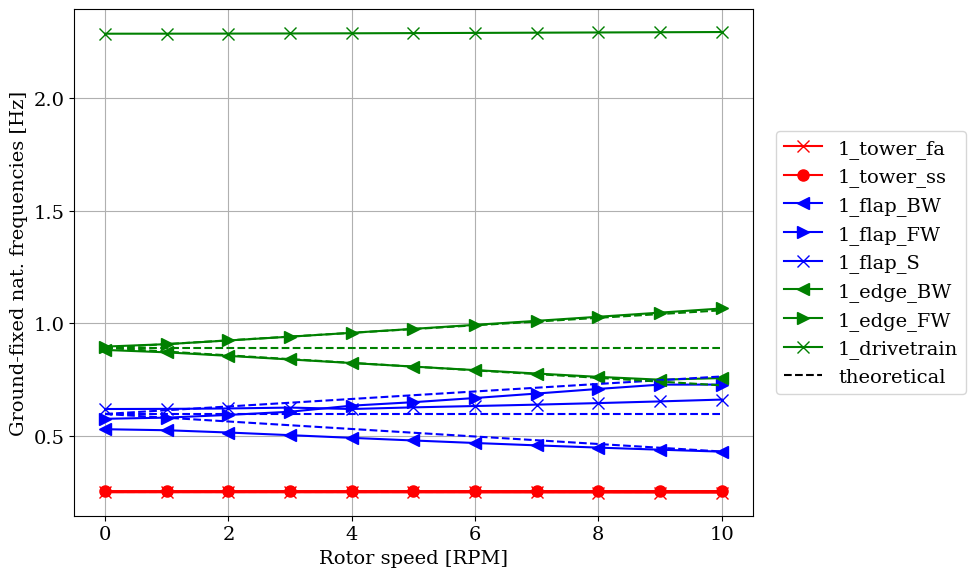

In [2]:

TURBINE_NAME = 'remodel'
CMB_PATH = 'remodel/hawcstab2/remodel_structural_freq.cmb'
#MODE_NAMES = ['Mode 2', 'Mode 3', 'Mode 4', 'Mode 5', 'Mode 6',
#              'Mode 7', 'Mode 8', 'Mode 9']
MODE_NAMES = ['1_tower_fa', '1_tower_ss', '1_flap_BW', '1_flap_FW', '1_flap_S',
              '1_edge_BW', '1_edge_FW', '1_drivetrain']

mode_names = ["Tower base FA", "Tower base SS", "1st BW flap", "1st FW flap", "1st SYM flap",  "1st BW edge", "1st FW edge", "drivetrain", "2nd FW flap",  "1st SYM edge",
              "2nd SYM flap","1P, 3P, 6P"]

DT_MODENUM = 12  # what mode number in HAWCStab2 is the drivetrain mode?
# define turbine natural frequency? blade-only natural frequencies?

# load campbell diagram
omega, dfreqs, _ = load_cmb(CMB_PATH, cmb_type='structural')
omega_rpm = omega * 30 / np.pi  # from rad/s to RPM
NNODES = len(omega_rpm)
nmodes = dfreqs.shape[1]

# swap modes 5 and 6 after 3 RPM. hawcstab2 mixed them up at the crossing.
# note that numpy index is off by 2 because of python + skipping rigid-body mode.
SWAP_RPM = 3
dfreq_mode5 = dfreqs[omega_rpm > SWAP_RPM, 3]
dfreqs[omega_rpm > SWAP_RPM, 3] = dfreqs[omega_rpm > SWAP_RPM, 4]
dfreqs[omega_rpm > SWAP_RPM, 4] = dfreq_mode5


# single blade
CMB_blade_PATH = 'remodel/hawcstab2/remodel_structural_blade_freq.cmb'
omega_b, dfreqs_b, _ = load_cmb(CMB_blade_PATH, cmb_type='structural')
tower = (dfreqs[0, 0] + dfreqs[0, 1])/2

blade_1flap =  dfreqs_b[0, 0]
blade_1edge =  dfreqs_b[0, 1]
print(blade_1flap)

# theoretical values
th_1flap_S = np.ones(NNODES)*blade_1flap
th_1flap_BW = th_1flap_S - omega/(2*np.pi)
th_1flap_FW = th_1flap_S + omega/(2*np.pi)

th_1edge_S = np.ones(NNODES)*blade_1edge
th_1edge_BW = th_1edge_S - omega/(2*np.pi)
th_1edge_FW = th_1edge_S + omega/(2*np.pi)

th_tower = np.ones(NNODES)*tower

P1 = omega/(2*np.pi)
P3 = P1*3
P6 = P1*6


# harmonic data
P_harm_path = "remodel/data/remodel_flex2.opt"
P_harm_data = load_oper(P_harm_path)
P_want = [1,3,6]


NMODES = len(MODE_NAMES)


fig, ax = plt.subplots(figsize=(10, 6))
# plot tower
ax.plot(omega_rpm, dfreqs[:, 0], marker='x', c='r', label=MODE_NAMES[0], markersize=8)
ax.plot(omega_rpm, dfreqs[:, 1], marker='o', c='r', label=MODE_NAMES[1], markersize=8)
# plot 1 edge
ax.plot(omega_rpm, dfreqs[:, 2], marker='<', c='b', label=MODE_NAMES[2], markersize=8)
ax.plot(omega_rpm, dfreqs[:, 3], marker='>', c='b', label=MODE_NAMES[3], markersize=8)
ax.plot(omega_rpm, dfreqs[:, 4], marker='x', c='b', label=MODE_NAMES[4], markersize=8)

ax.plot(omega_rpm, dfreqs[:, 5], marker='<', c='g', label=MODE_NAMES[5], markersize=8)
ax.plot(omega_rpm, dfreqs[:, 6], marker='>', c='g', label=MODE_NAMES[6], markersize=8)
ax.plot(omega_rpm, dfreqs[:, DT_MODENUM], marker='x', c='g', label=MODE_NAMES[7], markersize=8)

# plot theoretical
ax.plot([], [], linestyle='--', color='k', label='theoretical')
ax.plot(omega_rpm, th_1flap_S,  c='b', linestyle='--')
ax.plot(omega_rpm, th_1flap_BW, c='b', linestyle='--')
ax.plot(omega_rpm, th_1flap_FW, c='b', linestyle='--')
ax.plot(omega_rpm, th_1edge_S,  c='g', linestyle='--')
ax.plot(omega_rpm, th_1edge_BW, c='g', linestyle='--')
ax.plot(omega_rpm, th_1edge_FW, c='g', linestyle='--')
ax.plot(omega_rpm, th_tower, c='r', linestyle='--')


#for P in P_want:
#    harmonic_line=ax.plot(P_harm_data["rotor_speed_rpm"],P*(P_harm_data["rotor_speed_rpm"]*(1/60)), color="black")


# prettify
ax.set(xlabel='Rotor speed [RPM]', ylabel='Ground-fixed nat. frequencies [Hz]')
ax.grid()
ax.legend(bbox_to_anchor=(1.02, 0.5), loc='center left')

# add figure title and scale nicely
#fig.suptitle(f'Structural Campbell diagram for {TURBINE_NAME}')
fig.tight_layout()
plt.savefig('plots/ma_structural_campbell.pdf', format='pdf')
plt.show()


0.596767


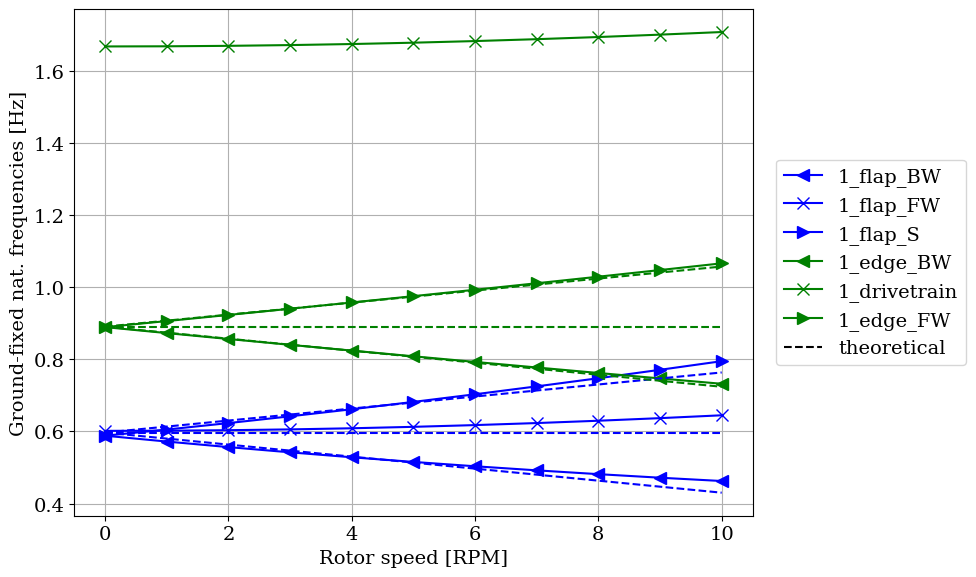

In [ ]:
# no tower flexibility

CMB_PATH = 'remodel/hawcstab2/remodel_structural_notower_freq.cmb'
#MODE_NAMES = ['Mode 2', 'Mode 3', 'Mode 4', 'Mode 5', 'Mode 6',
#              'Mode 7', 'Mode 8', 'Mode 9']
MODE_NAMES = ['1_flap_BW', '1_flap_FW', '1_flap_S',
              '1_edge_BW', '1_edge_FW', '1_drivetrain']

DT_MODENUM = 7  # what mode number in HAWCStab2 is the drivetrain mode?
# define turbine natural frequency? blade-only natural frequencies?

# load campbell diagram
omega, dfreqs, _ = load_cmb(CMB_PATH, cmb_type='structural')
omega_rpm = omega * 30 / np.pi  # from rad/s to RPM
NNODES = len(omega_rpm)

# single blade
CMB_blade_PATH = 'remodel/hawcstab2/remodel_structural_blade_freq.cmb'
omega_b, dfreqs_b, _ = load_cmb(CMB_blade_PATH, cmb_type='structural')

blade_1flap =  dfreqs_b[0, 0]
blade_1edge =  dfreqs_b[0, 1]

# theoretical values
th_1flap_S = np.ones(NNODES)*blade_1flap
th_1flap_BW = th_1flap_S - omega/(2*np.pi)
th_1flap_FW = th_1flap_S + omega/(2*np.pi)

th_1edge_S = np.ones(NNODES)*blade_1edge
th_1edge_BW = th_1edge_S - omega/(2*np.pi)
th_1edge_FW = th_1edge_S + omega/(2*np.pi)

P1 = omega/(2*np.pi)
P3 = P1*3
P6 = P1*6

NMODES = len(MODE_NAMES)

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(omega_rpm, dfreqs[:, 1], marker='<', c='b', label=MODE_NAMES[0], markersize=8)
ax.plot(omega_rpm, dfreqs[:, 2], marker='x', c='b', label=MODE_NAMES[1], markersize=8)
ax.plot(omega_rpm, dfreqs[:, 0], marker='>', c='b', label=MODE_NAMES[2], markersize=8)
ax.plot(omega_rpm, dfreqs[:, 3], marker='<', c='g', label=MODE_NAMES[3], markersize=8)
ax.plot(omega_rpm, dfreqs[:, DT_MODENUM], marker='x', c='g', label=MODE_NAMES[5], markersize=8)
ax.plot(omega_rpm, dfreqs[:, 4], marker='>', c='g', label=MODE_NAMES[4], markersize=8)

# plot theoretical
ax.plot([], [], linestyle='--', color='k', label='theoretical')
ax.plot(omega_rpm, th_1flap_S,  c='b', linestyle='--')
ax.plot(omega_rpm, th_1flap_BW, c='b', linestyle='--')
ax.plot(omega_rpm, th_1flap_FW, c='b', linestyle='--')
ax.plot(omega_rpm, th_1edge_S,  c='g', linestyle='--')
ax.plot(omega_rpm, th_1edge_BW, c='g', linestyle='--')
ax.plot(omega_rpm, th_1edge_FW, c='g', linestyle='--')
#ax.plot(omega_rpm, P1, c='k', linestyle='-', label='1P', zorder=1)
#ax.plot(omega_rpm, P3, c='k', linestyle='-', label='3P', zorder=1)
#ax.plot(omega_rpm, P6, c='k', linestyle='-', label='6P', zorder=1)


# prettify
ax.set(xlabel='Rotor speed [RPM]', ylabel='Ground-fixed nat. frequencies [Hz]')
ax.grid()
ax.legend(bbox_to_anchor=(1.02, 0.5), loc='center left')

# add figure title and scale nicely
#fig.suptitle(f'Structural Campbell diagram for {TURBINE_NAME}')
fig.tight_layout()
#plt.savefig('plots/01_structural_campbell_no_tower.pdf', format='pdf')
plt.show()


In [15]:
# compare frequency

omega_rem, dfreqs_rem, _ = load_cmb('remodel/hawcstab2/remodel_structural_blade_freq.cmb', cmb_type='structural')
rem_1flap =  dfreqs_rem[0, 0]
rem_1edge =  dfreqs_rem[0, 1]
print('rem flap', rem_1flap)
print('rem edge', rem_1edge)

omega_DTU, dfreqs_DTU, _ = load_cmb('dtu_10mw/hawcstab2/dtu_structural_blade_freq', cmb_type='structural')
DTU_1flap =  dfreqs_DTU[0, 0]
DTU_1edge =  dfreqs_DTU[0, 1]
print('DTU flap', DTU_1flap)
print('DTU edge', DTU_1edge)

omega_our, dfreqs_our, _ = load_cmb('our_design/hawcstab2/hawcstab2_structural_campbell_blade.cmb', cmb_type='structural')
our_1flap =  dfreqs_our[0, 0]
our_1edge =  dfreqs_our[0, 1]
print('our flap', our_1flap)
print('our edge', our_1edge)

print(rem_1flap, rem_1edge)
print(DTU_1flap, DTU_1edge)
print(our_1flap, our_1edge)


rem flap 0.596767
rem edge 0.890445
DTU flap 0.610456
DTU edge 0.930608
our flap 0.590303
our edge 0.882384
0.596767 0.890445
0.610456 0.930608
0.590303 0.882384


In [4]:
# structural amp file

'''
# Path to the .amp file
amp_path = 'remodel/hawcstab2/remodel_structural_amp'
amp_df = load_amp(amp_path)

print(amp_df.columns)
amp_df.columns = amp_df.columns.to_series().replace('Rotor speed', 'Wind speed')
#amp_df = amp_df.iloc[:, :-29]


wsp = amp_df['Wind speed'][1]
mode_names = [f'Mode {i}' for i in range(1, 12)]
wsp_1 = 1  # choose a wind speed
fig, ax = plot_amp(amp_df, mode_names, wsp, title=f'DTU 10 MW structural modal amplitudes at {wsp*30 / np.pi:.1f} rpm')
#plt.savefig('plots/01_amplitude.pdf', format='pdf')
plt.show()
'''

"\n# Path to the .amp file\namp_path = 'remodel/hawcstab2/remodel_structural_amp'\namp_df = load_amp(amp_path)\n\nprint(amp_df.columns)\namp_df.columns = amp_df.columns.to_series().replace('Rotor speed', 'Wind speed')\n#amp_df = amp_df.iloc[:, :-29]\n\n\nwsp = amp_df['Wind speed'][1]\nmode_names = [f'Mode {i}' for i in range(1, 12)]\nwsp_1 = 1  # choose a wind speed\nfig, ax = plot_amp(amp_df, mode_names, wsp, title=f'DTU 10 MW structural modal amplitudes at {wsp*30 / np.pi:.1f} rpm')\n#plt.savefig('plots/01_amplitude.pdf', format='pdf')\nplt.show()\n"

In [5]:
# structural no tower amp file

'''
# Path to the .amp file
amp_path = 'remodel/remodel_structural_amp_no_tower.amp'
amp_df = load_amp(amp_path)

print(amp_df.columns)
amp_df.columns = amp_df.columns.to_series().replace('Rotor speed', 'Wind speed')
#amp_df = amp_df.iloc[:, :-29]


wsp = amp_df['Wind speed'][1]
mode_names = [f'Mode {i}' for i in range(1, 12)]
wsp_1 = 0.1  # choose a wind speed
fig, ax = plot_amp(amp_df, mode_names, wsp, title=f'DTU 10 MW structural modal amplitudes at {wsp*30 / np.pi:.1f} rpm')
#plt.savefig('plots/01_amplitude.pdf', format='pdf')
plt.show()
'''

"\n# Path to the .amp file\namp_path = 'remodel/remodel_structural_amp_no_tower.amp'\namp_df = load_amp(amp_path)\n\nprint(amp_df.columns)\namp_df.columns = amp_df.columns.to_series().replace('Rotor speed', 'Wind speed')\n#amp_df = amp_df.iloc[:, :-29]\n\n\nwsp = amp_df['Wind speed'][1]\nmode_names = [f'Mode {i}' for i in range(1, 12)]\nwsp_1 = 0.1  # choose a wind speed\nfig, ax = plot_amp(amp_df, mode_names, wsp, title=f'DTU 10 MW structural modal amplitudes at {wsp*30 / np.pi:.1f} rpm')\n#plt.savefig('plots/01_amplitude.pdf', format='pdf')\nplt.show()\n"

## AEROELASTIC CAMPBELL

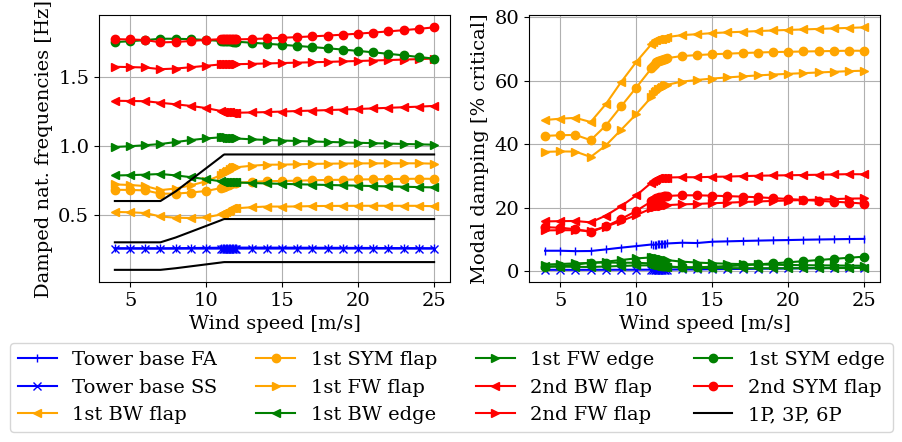

In [6]:
# aeroelastic campbell

cmb_path = "remodel/hawcstab2/remodel_aereolastic_freq.cmb"
cmb_type = "aeroelastic"

# Load the data
wsp, dfreqs, zetas = load_cmb(cmb_path, cmb_type)  # wind speed, damped natural freqs, and damping values

# print the shape
# dfreqs.shape  # n_wsp x n_modes

# extract data from HAWC result
P_harm_path = "remodel/data/remodel_flex2.opt"
P_harm_data = load_oper(P_harm_path)


nmodes = dfreqs.shape[1]  # get number of modes

P_want = [1,3,6]

mode_names = ["Tower base FA", "Tower base SS", "1st BW flap", "1st SYM flap", "1st FW flap", "1st BW edge", "1st FW edge", "2nd BW flap", "2nd FW flap",  "1st SYM edge",
              "2nd SYM flap","1P, 3P, 6P"]

mode_color = ["blue","blue","orange","orange","orange","green","green","red","red","green","red"]
mode_marker = ["|","x","<","o",">","<",">","<",">","o","o"]
fig, axs = plt.subplots(1, 2, figsize=(9, 4.5))


# left plot: damped nat freqs in ground-fixed frame

for k in range (11):
    axs[0].plot(wsp, dfreqs[:,k], color=mode_color[k], marker=mode_marker[k])#, label=mode_names[k])

for P in P_want:
    harmonic_line=axs[0].plot(P_harm_data["ws_ms"],P*(P_harm_data["rotor_speed_rpm"]*(1/60)), color="black")

axs[0].set(xlabel='Wind speed [m/s]', ylabel='Damped nat. frequencies [Hz]')
axs[0].grid()

# right plot: percent criticl damping
for k in range (11):
    lines = axs[1].plot(wsp, zetas[:,k], color=mode_color[k], marker=mode_marker[k])
axs[1].set(xlabel='Wind speed [m/s]', ylabel='Modal damping [% critical]')
axs[1].grid()

lines=lines.append(harmonic_line)

#fig.tight_layout()
#fig.subplots_adjust(bottom=0.2)
#fig.legend(loc='outside upper center', handles=lines, labels=mode_names, ncols=6)


fig.tight_layout()
plt.subplots_adjust(bottom=0.35) 
fig.legend(loc='lower center', handles=lines, labels=mode_names, ncols=4, bbox_to_anchor=(0.5, -0.005))
fig.savefig(f'plots/ma_aeroelastic.pdf', format='pdf',bbox_inches='tight')
plt.show()

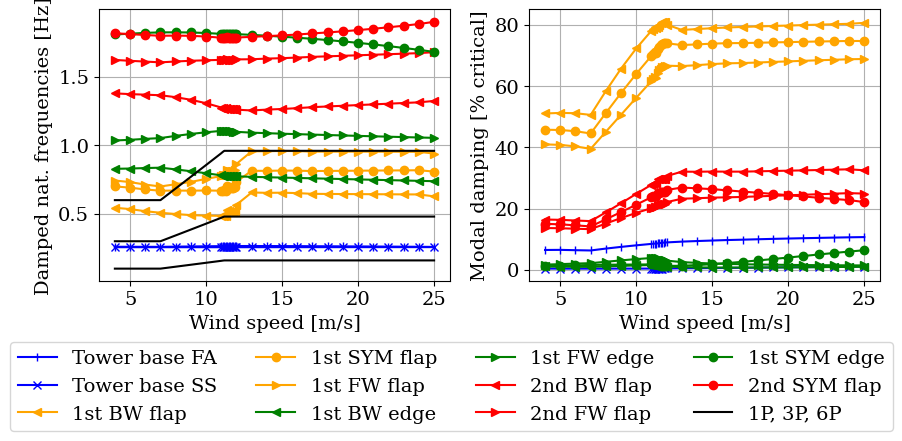

In [7]:
# aeroelastic campbell for DTU

cmb_path = "dtu_10mw/hawcstab2/dtu_aereolastic_freq"
cmb_type = "aeroelastic"

# Load the data
wsp, dfreqs, zetas = load_cmb(cmb_path, cmb_type)  # wind speed, damped natural freqs, and damping values

# print the shape
# dfreqs.shape  # n_wsp x n_modes

# extract data from HAWC result
P_harm_path = "dtu_10mw/data/dtu_10mw_flex_minrotspd.opt"
P_harm_data = load_oper(P_harm_path)


nmodes = dfreqs.shape[1]  # get number of modes

P_want = [1,3,6]

mode_names = ["Tower base FA", "Tower base SS", "1st BW flap", "1st SYM flap", "1st FW flap", "1st BW edge", "1st FW edge", "2nd BW flap", "2nd FW flap",  "1st SYM edge",
              "2nd SYM flap","1P, 3P, 6P"]

mode_color = ["blue","blue","orange","orange","orange","green","green","red","red","green","red"]
mode_marker = ["|","x","<","o",">","<",">","<",">","o","o"]
fig, axs = plt.subplots(1, 2, figsize=(9, 4.5))


# left plot: damped nat freqs in ground-fixed frame

for k in range (11):
    axs[0].plot(wsp, dfreqs[:,k], color=mode_color[k], marker=mode_marker[k])#, label=mode_names[k])

for P in P_want:
    harmonic_line=axs[0].plot(P_harm_data["ws_ms"],P*(P_harm_data["rotor_speed_rpm"]*(1/60)), color="black")

axs[0].set(xlabel='Wind speed [m/s]', ylabel='Damped nat. frequencies [Hz]')
axs[0].grid()

# right plot: percent criticl damping
for k in range (11):
    lines = axs[1].plot(wsp, zetas[:,k], color=mode_color[k], marker=mode_marker[k])
axs[1].set(xlabel='Wind speed [m/s]', ylabel='Modal damping [% critical]')
axs[1].grid()

lines=lines.append(harmonic_line)

#fig.tight_layout()
#fig.subplots_adjust(bottom=0.2)
#fig.legend(loc='outside upper center', handles=lines, labels=mode_names, ncols=6)


fig.tight_layout()
plt.subplots_adjust(bottom=0.35) 
fig.legend(loc='lower center', handles=lines, labels=mode_names, ncols=4, bbox_to_anchor=(0.5, -0.005))
fig.savefig(f'plots/ma_aeroelastic_dtu.pdf', format='pdf',bbox_inches='tight')
plt.show()

C:\Users\nicol\dtulac\src\lacbox\io.py:85: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(path, delim_whitespace=True, comment='#', header=None)


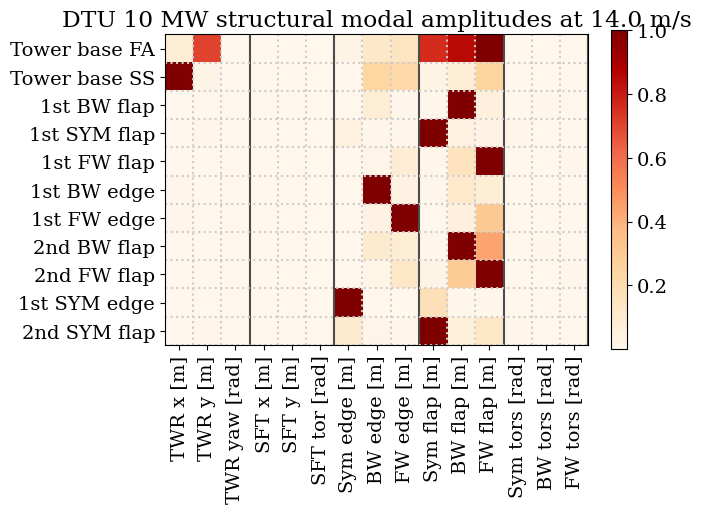

In [8]:
# Path to the .amp file
amp_path = 'remodel/hawcstab2/remodel_aeroelastic_amp'

# Load the modal amplitudes
amp_df = load_amp(amp_path)


wsp_1 = 14  # choose a wind speed
fig, ax = plot_amp(amp_df, mode_names[:-1], wsp_1, title=f'DTU 10 MW structural modal amplitudes at {wsp_1:.1f} m/s')
fig.savefig(f'plots/ma_amplitude.pdf', format='pdf',bbox_inches='tight')
plt.show()
